In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset, DatasetDict
from transformers import (
    T5Tokenizer, 
    T5ForConditionalGeneration,
    TrainingArguments,
    Trainer,
    DataCollatorForSeq2Seq
)
import torch
from torch.utils.data import DataLoader
import evaluate
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

# 设置matplotlib中文显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

print("所有库导入成功!")
print(f"PyTorch版本: {torch.__version__}")
print(f"CUDA可用: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU设备: {torch.cuda.get_device_name(0)}")

/root/miniconda3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/root/miniconda3/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


所有库导入成功!
PyTorch版本: 2.6.0+cu124
CUDA可用: True
GPU设备: NVIDIA GeForce RTX 3090


In [2]:
class T5QAModel:
    def __init__(self, model_name="/root/work/langboat/mengzi-t5-base", max_length=512):
        """
        初始化T5问答模型
        
        Args:
            model_name: 预训练模型名称
            max_length: 最大序列长度
        """
        self.model_name = model_name
        self.max_length = max_length
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        print(f"正在加载模型: {model_name}")
        
        # 初始化tokenizer和model
        self.tokenizer = T5Tokenizer.from_pretrained(model_name)
        self.model = T5ForConditionalGeneration.from_pretrained(model_name)
        self.model.to(self.device)
        
        # 初始化评估指标
        #self.bleu_metric = evaluate.load("bleu")
        
        print(f"✅ 模型已加载到设备: {self.device}")
        print(f"📊 模型参数数量: {self.model.num_parameters():,}")

    def load_data(self, data_path=None, data_list=None):
        """
        加载数据
        
        Args:
            data_path: 数据文件路径
            data_list: 直接传入的数据列表
        """
        if data_path:
            with open(data_path, 'r', encoding='utf-8') as f:
                data = [json.loads(line) for line in f]
        elif data_list:
            data = data_list
        else:
            # 使用示例数据
            data = [
                {
                    "context": "违规分为一般违规扣分，严重违规扣分、出售假冒商品违规扣分淘宝网每年12月31日24:00点会对符合条件的扣分做清零处理详情如下：赔偿提醒:由于出售假冒商品24≤N＜48分,当年的24分不清零,所以会存在第一年和第二年的不计扣分情况。",
                    "question": "淘宝扣分什么时候清零",
                    "answer": "12月31日24:00",
                    "id": 203
                },
                {
                    "context": "支付宝转账功能可以实现快速转账，用户可以通过手机号、邮箱或支付宝账号进行转账操作。转账通常在几分钟内完成，部分银行可能需要2小时。",
                    "question": "支付宝转账需要多长时间",
                    "answer": "几分钟内完成，部分银行可能需要2小时",
                    "id": 204
                },
                {
                    "context": "天猫超市是阿里巴巴集团旗下的网上购物平台，提供生鲜食品、日用百货等商品。天猫超市承诺当日达或次日达的配送服务。",
                    "question": "天猫超市的配送时间",
                    "answer": "当日达或次日达",
                    "id": 205
                },
                {
                    "context": "京东白条是京东推出的一种消费信贷产品，用户可以先消费后付款。白条支持分期付款，最长可分24期，手续费根据分期数不同而变化。",
                    "question": "京东白条最长可以分几期",
                    "answer": "最长可分24期",
                    "id": 206
                },
                {
                    "context": "微信支付是腾讯公司推出的移动支付服务，支持线上线下支付、转账、红包等功能。微信支付每日转账限额为20万元。",
                    "question": "微信支付每日转账限额是多少",
                    "answer": "20万元",
                    "id": 207
                }
            ]
        
        self.raw_data = data
        print(f"✅ 数据加载完成，共 {len(data)} 条记录")
        
        # 显示数据样例
        print("\n📋 数据样例:")
        for i, item in enumerate(data[:2]):
            print(f"样例 {i+1}:")
            print(f"  问题: {item['question']}")
            print(f"  答案: {item['answer']}")
            print(f"  上下文: {item['context'][:50]}...")
            print()
        
        return data

print("T5QAModel 类定义完成!")

T5QAModel 类定义完成!


In [3]:
qa_model = T5QAModel()

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


正在加载模型: /root/work/langboat/mengzi-t5-base
✅ 模型已加载到设备: cuda
📊 模型参数数量: 247,577,856


In [4]:
data = qa_model.load_data("/root/work/data/train.json")

✅ 数据加载完成，共 14520 条记录

📋 数据样例:
样例 1:
  问题: 仙剑奇侠传3第几集上天界
  答案: 第35集
  上下文: 第35集雪见缓缓张开眼睛，景天又惊又喜之际，长卿和紫萱的仙船驶至，见众人无恙，也十分高兴。众人登船，...

样例 2:
  问题: 燃气热水器哪个牌子好
  答案: 方太
  上下文: 选择燃气热水器时，一定要关注这几个问题：1、出水稳定性要好，不能出现忽热忽冷的现象2、快速到达设定的...



In [5]:
def preprocess_data(qa_model, train_ratio=0.7, val_ratio=0.2):
    """
    数据预处理和分割
    
    Args:
        qa_model: T5QAModel实例
        train_ratio: 训练集比例
        val_ratio: 验证集比例
    """
    print("🔄 开始数据预处理...")
    
    # 数据分割
    np.random.shuffle(qa_model.raw_data)
    total_len = len(qa_model.raw_data)
    train_len = int(total_len * train_ratio)
    val_len = int(total_len * val_ratio)
    
    train_data = qa_model.raw_data[:train_len]
    val_data = qa_model.raw_data[train_len:train_len + val_len]
    test_data = qa_model.raw_data[train_len + val_len:]
    
    print(f"📊 数据分割:")
    print(f"  训练集: {len(train_data)} 条 ({len(train_data)/total_len*100:.1f}%)")
    print(f"  验证集: {len(val_data)} 条 ({len(val_data)/total_len*100:.1f}%)")
    print(f"  测试集: {len(test_data)} 条 ({len(test_data)/total_len*100:.1f}%)")
    
    # 转换为Dataset格式
    def format_data(data):
        formatted = []
        for item in data:
            # T5格式：question: {question} context: {context}
            input_text = f"question: {item['question']} context: {item['context']}"
            formatted.append({
                "input_text": input_text,
                "target_text": item['answer']
            })
        return formatted
    
    train_formatted = format_data(train_data)
    val_formatted = format_data(val_data)
    test_formatted = format_data(test_data)
    
    # 创建Dataset对象
    qa_model.train_dataset = Dataset.from_list(train_formatted)
    qa_model.val_dataset = Dataset.from_list(val_formatted)
    qa_model.test_dataset = Dataset.from_list(test_formatted)
    qa_model.test_data_raw = test_data  # 保存原始测试数据用于后续评估
    
    # 显示格式化后的样例
    print("\n📋 格式化后的样例:")
    print(f"输入: {train_formatted[0]['input_text'][:100]}...")
    print(f"目标: {train_formatted[0]['target_text']}")
    
    return qa_model.train_dataset, qa_model.val_dataset, qa_model.test_dataset

# 执行数据预处理
train_dataset, val_dataset, test_dataset = preprocess_data(qa_model)

🔄 开始数据预处理...
📊 数据分割:
  训练集: 10164 条 (70.0%)
  验证集: 2904 条 (20.0%)
  测试集: 1452 条 (10.0%)

📋 格式化后的样例:
输入: question: 2岁宝宝用什么枕头好 context: 用蚕沙枕头吧。蚕沙具有去风降湿，和胃化浊，明目降压的功效，对眼疾，接膜炎，心慌，神经衰弱， 失眠 ，偏头痛，高血压，肝火旺， 消化不良 ， ...
目标: 蚕沙枕头


In [6]:
def tokenize_data(qa_model):
    """
    对数据进行tokenization
    """
    print("🔄 开始数据Tokenization...")
    
    def tokenize_function(examples):
        # Tokenize inputs
        model_inputs = qa_model.tokenizer(
            examples["input_text"], 
            max_length=qa_model.max_length, 
            truncation=True, 
            padding=False
        )
        
        # Tokenize targets
        with qa_model.tokenizer.as_target_tokenizer():
            labels = qa_model.tokenizer(
                examples["target_text"], 
                max_length=128, 
                truncation=True, 
                padding=False
            )
        
        model_inputs["labels"] = labels["input_ids"]
        return model_inputs
    
    # 应用tokenization
    qa_model.train_dataset = qa_model.train_dataset.map(
        tokenize_function, 
        batched=True, 
        remove_columns=qa_model.train_dataset.column_names
    )
    
    qa_model.val_dataset = qa_model.val_dataset.map(
        tokenize_function, 
        batched=True, 
        remove_columns=qa_model.val_dataset.column_names
    )
    
    if len(qa_model.test_dataset) > 0:
        qa_model.test_dataset = qa_model.test_dataset.map(
            tokenize_function, 
            batched=True, 
            remove_columns=qa_model.test_dataset.column_names
        )
    
    print("✅ 数据tokenization完成")
    
    # 显示tokenization后的信息
    print(f"📊 Tokenization统计:")
    sample = qa_model.train_dataset[0]
    print(f"  输入序列长度: {len(sample['input_ids'])}")
    print(f"  标签序列长度: {len(sample['labels'])}")

# 执行tokenization
tokenize_data(qa_model)

🔄 开始数据Tokenization...


Map:   0%|          | 0/10164 [00:00<?, ? examples/s]

Map:   0%|          | 0/2904 [00:00<?, ? examples/s]

Map:   0%|          | 0/1452 [00:00<?, ? examples/s]

✅ 数据tokenization完成
📊 Tokenization统计:
  输入序列长度: 138
  标签序列长度: 4


In [17]:
def setup_training_args(output_dir="/root/autodl-tmp/t5-qa-finetuned", epochs=3, batch_size=2, learning_rate=5e-5):
    """
    设置训练参数
    """
    print("⚙️ 设置训练参数...")
    
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir=f'{output_dir}/logs',
        logging_steps=5,
        evaluation_strategy="steps",
        eval_steps=5000,
        save_strategy="steps",
        save_steps=5000,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        learning_rate=learning_rate,
        fp16=torch.cuda.is_available(),  # 使用混合精度训练
        dataloader_pin_memory=False,
        remove_unused_columns=True,
        report_to=None,  # 禁用wandb等日志记录
    )
    
    print(f"📋 训练配置:")
    print(f"  输出目录: {output_dir}")
    print(f"  训练轮数: {epochs}")
    print(f"  批次大小: {batch_size}")
    print(f"  学习率: {learning_rate}")
    print(f"  混合精度: {torch.cuda.is_available()}")
    
    return training_args

# 设置训练参数
training_args = setup_training_args(epochs=3, batch_size=1, learning_rate=5e-5)


⚙️ 设置训练参数...
📋 训练配置:
  输出目录: /root/autodl-tmp/t5-qa-finetuned
  训练轮数: 3
  批次大小: 1
  学习率: 5e-05
  混合精度: True


In [18]:
def create_trainer(qa_model, training_args):
    """
    创建训练器
    """
    print("🔄 创建训练器...")
    
    # 数据整理器
    data_collator = DataCollatorForSeq2Seq(
        tokenizer=qa_model.tokenizer,
        model=qa_model.model,
        padding=True,
        return_tensors="pt"
    )
    
    # 创建Trainer
    trainer = Trainer(
        model=qa_model.model,
        args=training_args,
        train_dataset=qa_model.train_dataset,
        eval_dataset=qa_model.val_dataset,
        tokenizer=qa_model.tokenizer,
        data_collator=data_collator,
    )
    
    print("✅ 训练器创建完成")
    return trainer

# 创建训练器
trainer = create_trainer(qa_model, training_args)

🔄 创建训练器...
✅ 训练器创建完成


In [19]:
print("🚀 开始训练模型...")
print("注意: 这可能需要几分钟时间，请耐心等待...")

# 训练模型
train_result = trainer.train()

# 保存模型
trainer.save_model()
qa_model.tokenizer.save_pretrained(training_args.output_dir)

print("🎉 训练完成!")
print(f"✅ 模型已保存到 {training_args.output_dir}")
print(f"📊 最终训练损失: {train_result.training_loss:.4f}")

🚀 开始训练模型...
注意: 这可能需要几分钟时间，请耐心等待...


Step,Training Loss,Validation Loss
5000,0.871100,1.214954
10000,1.625000,0.966134
15000,0.349100,1.064773
20000,0.207800,0.971458
25000,0.067400,1.078134
30000,0.000400,1.055576


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


🎉 训练完成!
✅ 模型已保存到 /root/autodl-tmp/t5-qa-finetuned
📊 最终训练损失: 0.6353


📈 绘制训练曲线...


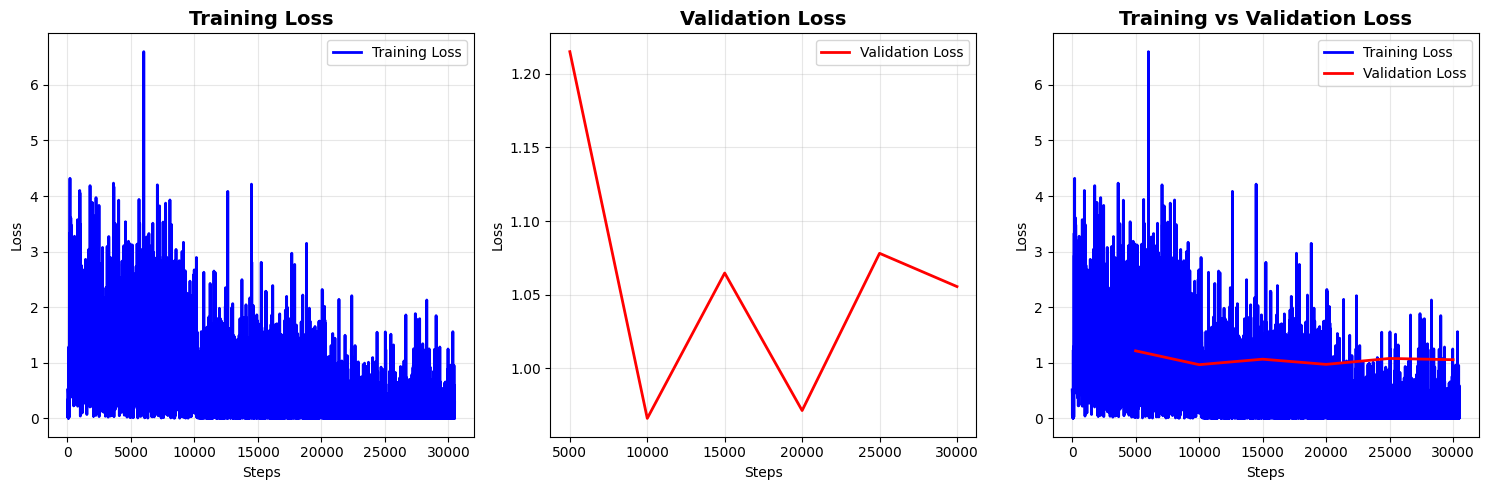

✅ 训练曲线已保存为 training_curves.png


In [20]:
def plot_training_curves(log_history):
    """
    绘制训练曲线
    """
    print("📈 绘制训练曲线...")
    
    train_losses = []
    eval_losses = []
    steps = []
    
    for log in log_history:
        if 'loss' in log:
            train_losses.append(log['loss'])
            steps.append(log['step'])
        if 'eval_loss' in log:
            eval_losses.append(log['eval_loss'])
    
    plt.figure(figsize=(15, 5))
    
    # 训练损失
    plt.subplot(1, 3, 1)
    plt.plot(steps[:len(train_losses)], train_losses, 'b-', label='Training Loss', linewidth=2)
    plt.title('Training Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 验证损失
    if eval_losses:
        plt.subplot(1, 3, 2)
        eval_steps = [log['step'] for log in log_history if 'eval_loss' in log]
        plt.plot(eval_steps, eval_losses, 'r-', label='Validation Loss', linewidth=2)
        plt.title('Validation Loss', fontsize=14, fontweight='bold')
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # 损失对比
    if eval_losses:
        plt.subplot(1, 3, 3)
        plt.plot(steps[:len(train_losses)], train_losses, 'b-', label='Training Loss', linewidth=2)
        plt.plot(eval_steps, eval_losses, 'r-', label='Validation Loss', linewidth=2)
        plt.title('Training vs Validation Loss', fontsize=14, fontweight='bold')
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ 训练曲线已保存为 training_curves.png")

# 绘制训练曲线
plot_training_curves(trainer.state.log_history)

In [21]:
def predict_answer(qa_model, context, question, max_new_tokens=128):
    """
    预测答案
    
    Args:
        qa_model: T5QAModel实例
        context: 上下文
        question: 问题
        max_new_tokens: 最大生成token数
        
    Returns:
        预测的答案
    """
    # 格式化输入
    input_text = f"question: {question} context: {context}"
    
    # Tokenize
    inputs = qa_model.tokenizer(
        input_text,
        return_tensors="pt",
        max_length=qa_model.max_length,
        truncation=True,
        padding=True
    ).to(qa_model.device)
    
    # 生成答案
    qa_model.model.eval()
    with torch.no_grad():
        outputs = qa_model.model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_new_tokens=max_new_tokens,
            num_beams=4,
            early_stopping=True,
            do_sample=False,
            temperature=1.0,
            pad_token_id=qa_model.tokenizer.pad_token_id
        )
    
    # 解码答案
    answer = qa_model.tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer

print("✅ 预测函数定义完成")

✅ 预测函数定义完成


In [22]:
# 测试单个预测
sample_context = "违规分为一般违规扣分，严重违规扣分、出售假冒商品违规扣分淘宝网每年12月31日24:00点会对符合条件的扣分做清零处理"
sample_question = "淘宝扣分什么时候清零"

print("🔮 单个预测测试:")
print(f"问题: {sample_question}")
print(f"上下文: {sample_context}")
print("\n预测中...")

predicted_answer = predict_answer(qa_model, sample_context, sample_question)
print(f"✨ 预测答案: {predicted_answer}")

🔮 单个预测测试:
问题: 淘宝扣分什么时候清零
上下文: 违规分为一般违规扣分，严重违规扣分、出售假冒商品违规扣分淘宝网每年12月31日24:00点会对符合条件的扣分做清零处理

预测中...
✨ 预测答案: 12月31日


In [24]:
def batch_predict_and_evaluate(qa_model):
    """
    批量预测和评估
    """
    if not hasattr(qa_model, 'test_data_raw') or len(qa_model.test_data_raw) == 0:
        print("⚠️  没有测试数据，使用部分训练数据进行测试...")
        test_data = qa_model.raw_data[:3]
    else:
        test_data = qa_model.test_data_raw[:10] #这里为了防止输出太多，只预测前10个，可自定义修改
    
    print(f"🔮 开始批量预测 ({len(test_data)} 个样本)...")
    
    predictions = []
    references = []
    
    for i, item in enumerate(tqdm(test_data, desc="预测中")):
        prediction = predict_answer(qa_model, item['context'], item['question'])
        predictions.append(prediction)
        references.append(item['answer'])
        
        print(f"\n样本 {i+1}:")
        print(f"  问题: {item['question']}")
        print(f"  真实答案: {item['answer']}")
        print(f"  预测答案: {prediction}")
        print(f"  匹配: {'✅' if prediction.strip() == item['answer'].strip() else '❌'}")
    
    return predictions, references, test_data

# 执行批量预测
predictions, references, test_data = batch_predict_and_evaluate(qa_model)

🔮 开始批量预测 (10 个样本)...


预测中:  10%|█         | 1/10 [00:00<00:01,  6.29it/s]


样本 1:
  问题: epub用什么打开
  真实答案: WinRAR
  预测答案: WinRAR
  匹配: ✅


预测中:  20%|██        | 2/10 [00:00<00:01,  7.65it/s]


样本 2:
  问题: 魅族pro7什么时候上市
  真实答案: 2017年6月份
  预测答案: 2017年6月份
  匹配: ✅

样本 3:
  问题: 粽叶要泡多久
  真实答案: 12小时
  预测答案: 12小时
  匹配: ✅


预测中:  40%|████      | 4/10 [00:00<00:00, 10.12it/s]


样本 4:
  问题: 福鼎属于哪个市
  真实答案: 宁德市
  预测答案: 宁德市
  匹配: ✅

样本 5:
  问题: 一带一路何时提出
  真实答案: 2013年9月和10月
  预测答案: 2013年9月和10月
  匹配: ✅


预测中:  60%|██████    | 6/10 [00:00<00:00,  8.76it/s]


样本 6:
  问题: 荔枝能放几天
  真实答案: 2-3天
  预测答案: 2-3天
  匹配: ✅


预测中:  70%|███████   | 7/10 [00:00<00:00,  8.46it/s]


样本 7:
  问题: f15航程
  真实答案: 2800-3000公里
  预测答案: 2800-3000公里
  匹配: ✅


预测中:  80%|████████  | 8/10 [00:00<00:00,  8.27it/s]


样本 8:
  问题: 2017二级消防报名时间
  真实答案: 3月
  预测答案: 2017年3月
  匹配: ❌


预测中:  90%|█████████ | 9/10 [00:01<00:00,  8.11it/s]


样本 9:
  问题: au750是什么金
  真实答案: 18K金
  预测答案: 18K金
  匹配: ✅


预测中: 100%|██████████| 10/10 [00:01<00:00,  8.27it/s]


样本 10:
  问题: 成都到九寨沟跟团多少钱
  真实答案: 730
  预测答案: 730
  匹配: ✅


📊 模型性能评估...

📈 模型评估结果
📊 整体BLEU分数: 0.0000
📊 平均BLEU分数: 0.0000
📊 BLEU分数标准差: 0.0000
🎯 精确匹配数量: 9/10
🎯 精确匹配率: 90.00%
🎯 包含匹配数量: 10/10
🎯 包含匹配率: 100.00%


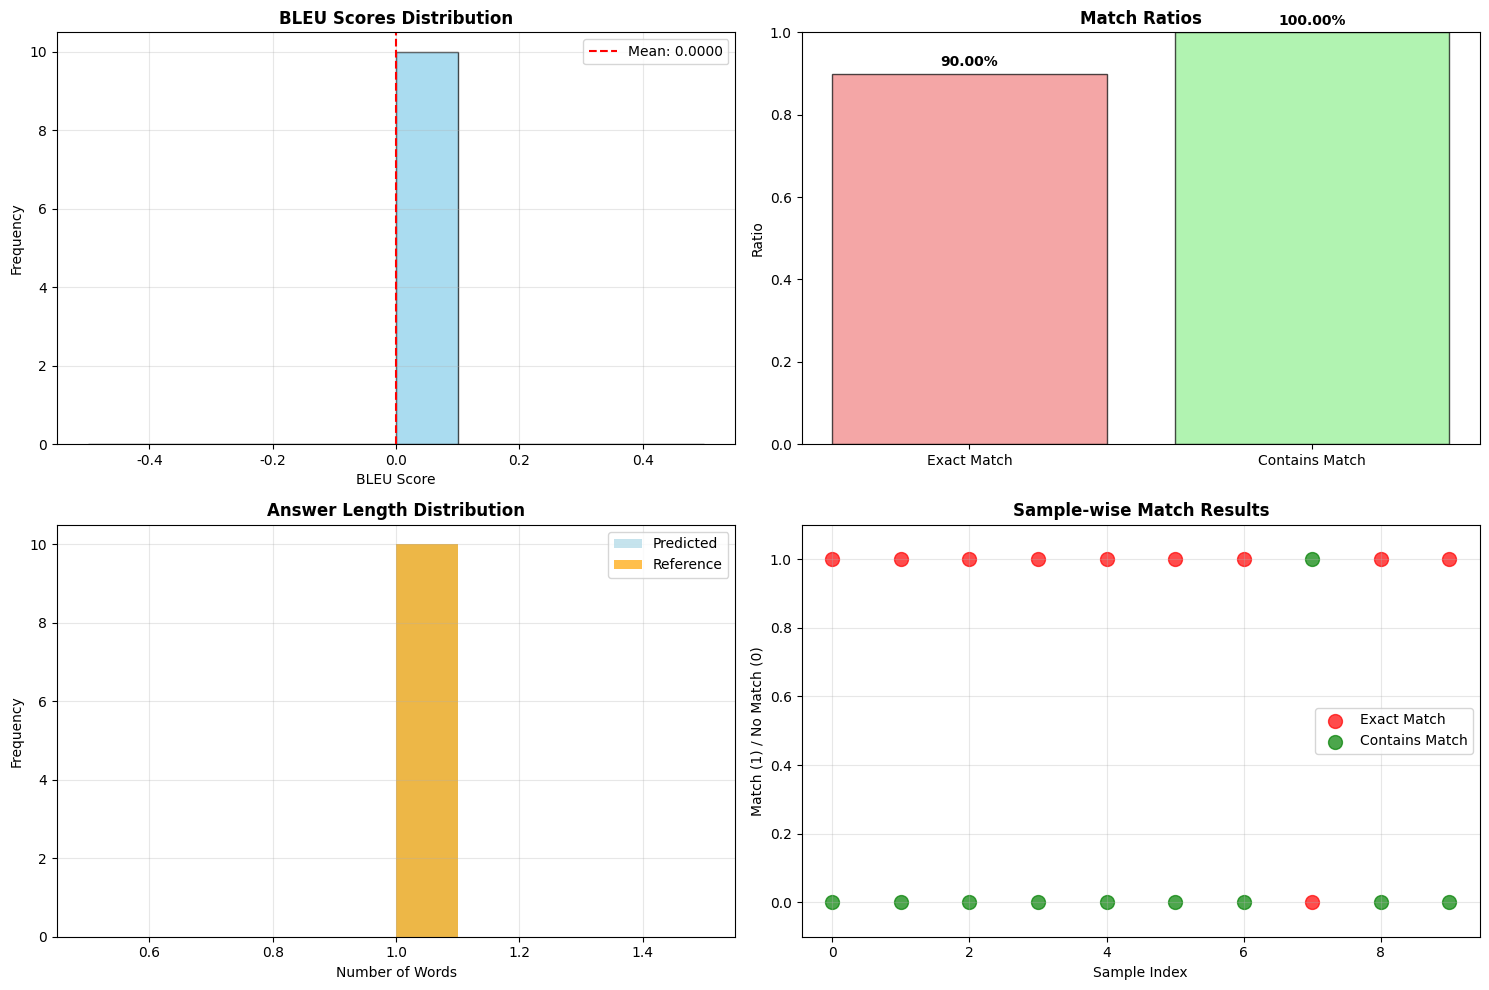

In [25]:
def evaluate_predictions(qa_model, predictions, references):
    """
    评估预测结果
    """
    print("📊 模型性能评估...")
    
    # 计算BLEU分数
    bleu_scores = []
    for pred, ref in zip(predictions, references):
        try:
            # 计算单个样本的BLEU分数
            bleu = qa_model.bleu_metric.compute(
                predictions=[pred.split()],
                references=[[ref.split()]]
            )
            bleu_scores.append(bleu['bleu'])
        except:
            bleu_scores.append(0.0)
    
    # 整体BLEU分数
    try:
        overall_bleu = qa_model.bleu_metric.compute(
            predictions=[pred.split() for pred in predictions],
            references=[[ref.split()] for ref in references]
        )['bleu']
    except:
        overall_bleu = 0.0
    
    # 计算其他指标
    exact_matches = sum([pred.strip() == ref.strip() for pred, ref in zip(predictions, references)])
    exact_match_ratio = exact_matches / len(predictions)
    
    # 计算包含匹配（预测答案包含真实答案或真实答案包含预测答案）
    contains_matches = sum([
        ref.strip() in pred.strip() or pred.strip() in ref.strip() 
        for pred, ref in zip(predictions, references)
    ])
    contains_match_ratio = contains_matches / len(predictions)
    
    print("\n" + "="*50)
    print("📈 模型评估结果")
    print("="*50)
    print(f"📊 整体BLEU分数: {overall_bleu:.4f}")
    print(f"📊 平均BLEU分数: {np.mean(bleu_scores):.4f}")
    print(f"📊 BLEU分数标准差: {np.std(bleu_scores):.4f}")
    print(f"🎯 精确匹配数量: {exact_matches}/{len(predictions)}")
    print(f"🎯 精确匹配率: {exact_match_ratio:.2%}")
    print(f"🎯 包含匹配数量: {contains_matches}/{len(predictions)}")
    print(f"🎯 包含匹配率: {contains_match_ratio:.2%}")
    print("="*50)
    
    # 绘制评估结果
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # BLEU分数分布
    axes[0, 0].hist(bleu_scores, bins=10, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].axvline(np.mean(bleu_scores), color='red', linestyle='--', 
                       label=f'Mean: {np.mean(bleu_scores):.4f}')
    axes[0, 0].set_title('BLEU Scores Distribution', fontweight='bold')
    axes[0, 0].set_xlabel('BLEU Score')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 匹配率对比
    match_types = ['Exact Match', 'Contains Match']
    match_ratios = [exact_match_ratio, contains_match_ratio]
    colors = ['lightcoral', 'lightgreen']
    
    bars = axes[0, 1].bar(match_types, match_ratios, color=colors, alpha=0.7, edgecolor='black')
    axes[0, 1].set_title('Match Ratios', fontweight='bold')
    axes[0, 1].set_ylabel('Ratio')
    axes[0, 1].set_ylim(0, 1)
    
    # 添加数值标签
    for bar, ratio in zip(bars, match_ratios):
        height = bar.get_height()
        axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{ratio:.2%}', ha='center', va='bottom', fontweight='bold')
    
    # 答案长度分布
    pred_lengths = [len(pred.split()) for pred in predictions]
    ref_lengths = [len(ref.split()) for ref in references]
    
    axes[1, 0].hist(pred_lengths, alpha=0.7, label='Predicted', bins=10, color='lightblue')
    axes[1, 0].hist(ref_lengths, alpha=0.7, label='Reference', bins=10, color='orange')
    axes[1, 0].set_title('Answer Length Distribution', fontweight='bold')
    axes[1, 0].set_xlabel('Number of Words')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 样本比较
    sample_indices = range(len(predictions))
    axes[1, 1].scatter(sample_indices, [1 if pred.strip() == ref.strip() else 0 
                                       for pred, ref in zip(predictions, references)], 
                       color='red', label='Exact Match', alpha=0.7, s=100)
    axes[1, 1].scatter(sample_indices, [1 if (ref.strip() in pred.strip() or pred.strip() in ref.strip()) 
                                        and pred.strip() != ref.strip() else 0 
                                       for pred, ref in zip(predictions, references)], 
                       color='green', label='Contains Match', alpha=0.7, s=100)
    axes[1, 1].set_title('Sample-wise Match Results', fontweight='bold')
    axes[1, 1].set_xlabel('Sample Index')
    axes[1, 1].set_ylabel('Match (1) / No Match (0)')
    axes[1, 1].set_ylim(-0.1, 1.1)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('evaluation_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return {
        'overall_bleu': overall_bleu,
        'mean_bleu': np.mean(bleu_scores),
        'std_bleu': np.std(bleu_scores),
        'exact_match_ratio': exact_match_ratio,
        'contains_match_ratio': contains_match_ratio,
        'predictions': predictions,
        'references': references
    }

# 执行评估
evaluation_results = evaluate_predictions(qa_model, predictions, references)

In [26]:
def save_predictions(predictions, references, test_data, filename="predictions.json"):
    """
    保存预测结果到JSON文件
    """
    results = []
    for i, (pred, ref, data) in enumerate(zip(predictions, references, test_data)):
        results.append({
            'id': data.get('id', i),
            'context': data['context'],
            'question': data['question'],
            'reference_answer': ref,
            'predicted_answer': pred,
            'exact_match': pred.strip() == ref.strip(),
            'contains_match': ref.strip() in pred.strip() or pred.strip() in ref.strip()
        })
    
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(results, f, ensure_ascii=False, indent=2)
    
    print(f"💾 预测结果已保存到 {filename}")
    
    # 创建DataFrame用于更好的显示
    df = pd.DataFrame(results)
    print("\n📋 预测结果预览:")
    display_columns = ['question', 'reference_answer', 'predicted_answer', 'exact_match']
    print(df[display_columns].to_string(index=False, max_colwidth=50))
    
    return results

# 保存预测结果
results = save_predictions(predictions, references, test_data)

💾 预测结果已保存到 predictions.json

📋 预测结果预览:
    question reference_answer predicted_answer  exact_match
   epub用什么打开           WinRAR           WinRAR         True
魅族pro7什么时候上市         2017年6月份         2017年6月份         True
      粽叶要泡多久             12小时             12小时         True
     福鼎属于哪个市              宁德市              宁德市         True
    一带一路何时提出      2013年9月和10月      2013年9月和10月         True
      荔枝能放几天             2-3天             2-3天         True
       f15航程      2800-3000公里      2800-3000公里         True
2017二级消防报名时间               3月          2017年3月        False
   au750是什么金             18K金             18K金         True
 成都到九寨沟跟团多少钱              730              730         True


In [27]:
def interactive_prediction(qa_model):
    """
    交互式预测
    """
    print("🎯 交互式问答测试")
    print("=" * 50)
    
    # 预设一些测试样例
    test_cases = [
        {
            "context": "微信支付是腾讯公司推出的移动支付服务，支持线上线下支付、转账、红包等功能。微信支付每日转账限额为20万元。",
            "question": "微信支付每日转账限额是多少"
        },
        {
            "context": "京东白条是京东推出的一种消费信贷产品，用户可以先消费后付款。白条支持分期付款，最长可分24期，手续费根据分期数不同而变化。",
            "question": "京东白条最长可以分几期"
        },
        {
            "context": "淘宝网是中国最大的网上购物平台，提供服装、电子产品、家居用品等商品。淘宝支持7天无理由退货，买家在收到商品后7天内可以申请退货。",
            "question": "淘宝支持多少天无理由退货"
        }
    ]
    
    print("📝 预设测试样例:")
    for i, case in enumerate(test_cases):
        print(f"\n样例 {i+1}:")
        print(f"问题: {case['question']}")
        print(f"上下文: {case['context'][:60]}...")
        
        # 预测答案
        answer = predict_answer(qa_model, case['context'], case['question'])
        print(f"✨ 预测答案: {answer}")
    
    print("\n" + "="*50)
    print("💡 您可以在下面的cell中自定义问题和上下文进行测试")

# 执行交互式预测
interactive_prediction(qa_model)


🎯 交互式问答测试
📝 预设测试样例:

样例 1:
问题: 微信支付每日转账限额是多少
上下文: 微信支付是腾讯公司推出的移动支付服务，支持线上线下支付、转账、红包等功能。微信支付每日转账限额为20万元。...
✨ 预测答案: 20万元

样例 2:
问题: 京东白条最长可以分几期
上下文: 京东白条是京东推出的一种消费信贷产品，用户可以先消费后付款。白条支持分期付款，最长可分24期，手续费根据分期数不同而变化...
✨ 预测答案: 24期

样例 3:
问题: 淘宝支持多少天无理由退货
上下文: 淘宝网是中国最大的网上购物平台，提供服装、电子产品、家居用品等商品。淘宝支持7天无理由退货，买家在收到商品后7天内可以申...
✨ 预测答案: 7天

💡 您可以在下面的cell中自定义问题和上下文进行测试


In [28]:
# 在这里您可以自定义问题和上下文进行测试
print("🔧 自定义预测测试")
print("请修改下面的变量进行测试:\n")

# 自定义您的测试用例
custom_context = "支付宝是蚂蚁集团推出的数字支付平台，支持扫码支付、转账、理财等功能。支付宝转账免费，但提现到银行卡每人每月有2万元免费额度。"
custom_question = "支付宝每月免费提现额度是多少"

print(f"问题: {custom_question}")
print(f"上下文: {custom_context}")
print("\n预测中...")

# 进行预测
custom_answer = predict_answer(qa_model, custom_context, custom_question)
print(f"✨ 预测答案: {custom_answer}")

🔧 自定义预测测试
请修改下面的变量进行测试:

问题: 支付宝每月免费提现额度是多少
上下文: 支付宝是蚂蚁集团推出的数字支付平台，支持扫码支付、转账、理财等功能。支付宝转账免费，但提现到银行卡每人每月有2万元免费额度。

预测中...
✨ 预测答案: 2万元


In [29]:
def analyze_model_performance(evaluation_results, predictions, references):
    """
    分析模型性能并提供改进建议
    """
    print("🔍 模型性能深度分析")
    print("=" * 60)
    
    # 错误分析
    errors = []
    correct = []
    
    for i, (pred, ref) in enumerate(zip(predictions, references)):
        if pred.strip() != ref.strip():
            errors.append({
                'index': i,
                'predicted': pred,
                'reference': ref,
                'error_type': 'mismatch'
            })
        else:
            correct.append({'index': i, 'predicted': pred, 'reference': ref})
    
    print(f"📊 错误分析:")
    print(f"  正确预测: {len(correct)} 个")
    print(f"  错误预测: {len(errors)} 个")
    
    if errors:
        print(f"\n❌ 错误样例分析:")
        for i, error in enumerate(errors[:3]):  # 显示前3个错误
            print(f"  错误 {i+1}:")
            print(f"    预测: {error['predicted']}")
            print(f"    真实: {error['reference']}")
            print(f"    类型: {error['error_type']}")
    
    # 答案长度分析
    pred_lengths = [len(pred.split()) for pred in predictions]
    ref_lengths = [len(ref.split()) for ref in references]
    
    print(f"\n📏 答案长度分析:")
    print(f"  预测答案平均长度: {np.mean(pred_lengths):.2f} 词")
    print(f"  真实答案平均长度: {np.mean(ref_lengths):.2f} 词")
    print(f"  长度差异: {abs(np.mean(pred_lengths) - np.mean(ref_lengths)):.2f} 词")
    
    # 改进建议
    print(f"\n💡 模型改进建议:")
    
    if evaluation_results['exact_match_ratio'] < 0.5:
        print("  🔧 精确匹配率较低，建议:")
        print("     - 增加训练数据量")
        print("     - 调整学习率和训练轮数")
        print("     - 考虑使用更大的预训练模型")
    
    if evaluation_results['mean_bleu'] < 0.3:
        print("  🔧 BLEU分数较低，建议:")
        print("     - 改进数据预处理方法")
        print("     - 调整生成参数（beam size等）")
        print("     - 使用更高质量的训练数据")
    
    if np.mean(pred_lengths) > np.mean(ref_lengths) * 1.5:
        print("  🔧 预测答案过长，建议:")
        print("     - 减少max_new_tokens参数")
        print("     - 调整生成策略")
        print("     - 在训练数据中强调简洁性")
    
    print(f"\n✅ 模型整体表现: ", end="")
    if evaluation_results['exact_match_ratio'] >= 0.7:
        print("优秀 🏆")
    elif evaluation_results['exact_match_ratio'] >= 0.5:
        print("良好 👍")
    elif evaluation_results['exact_match_ratio'] >= 0.3:
        print("一般 ⚠️")
    else:
        print("需要改进 🔧")

# 执行性能分析
analyze_model_performance(evaluation_results, predictions, references)

🔍 模型性能深度分析
📊 错误分析:
  正确预测: 9 个
  错误预测: 1 个

❌ 错误样例分析:
  错误 1:
    预测: 2017年3月
    真实: 3月
    类型: mismatch

📏 答案长度分析:
  预测答案平均长度: 1.00 词
  真实答案平均长度: 1.00 词
  长度差异: 0.00 词

💡 模型改进建议:
  🔧 BLEU分数较低，建议:
     - 改进数据预处理方法
     - 调整生成参数（beam size等）
     - 使用更高质量的训练数据

✅ 模型整体表现: 优秀 🏆


In [30]:
def save_model_info(qa_model, training_args, evaluation_results):
    """
    保存模型信息
    """
    model_info = {
        'model_name': qa_model.model_name,
        'max_length': qa_model.max_length,
        'training_args': {
            'epochs': training_args.num_train_epochs,
            'batch_size': training_args.per_device_train_batch_size,
            'learning_rate': training_args.learning_rate,
        },
        'performance': {
            'exact_match_ratio': evaluation_results['exact_match_ratio'],
            'mean_bleu': evaluation_results['mean_bleu'],
            'overall_bleu': evaluation_results['overall_bleu'],
        },
        'timestamp': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
    }
    
    with open('model_info.json', 'w', encoding='utf-8') as f:
        json.dump(model_info, f, ensure_ascii=False, indent=2)
    
    print("💾 模型信息已保存到 model_info.json")
    print(f"📁 模型文件保存在: {training_args.output_dir}")
    print("\n📋 模型信息摘要:")
    print(f"  模型: {model_info['model_name']}")
    print(f"  训练轮数: {model_info['training_args']['epochs']}")
    print(f"  精确匹配率: {model_info['performance']['exact_match_ratio']:.2%}")
    print(f"  平均BLEU: {model_info['performance']['mean_bleu']:.4f}")

save_model_info(qa_model, training_args, evaluation_results)

💾 模型信息已保存到 model_info.json
📁 模型文件保存在: /root/autodl-tmp/t5-qa-finetuned

📋 模型信息摘要:
  模型: /root/work/langboat/mengzi-t5-base
  训练轮数: 3
  精确匹配率: 90.00%
  平均BLEU: 0.0000


In [ ]:
print("🎉 T5问答模型训练完成!")
print("=" * 60)

print("\n📊 训练总结:")
print(f"  ✅ 数据加载: {len(qa_model.raw_data)} 条记录")
print(f"  ✅ 模型训练: 完成 {training_args.num_train_epochs} 轮训练")
print(f"  ✅ 模型评估: 精确匹配率 {evaluation_results['exact_match_ratio']:.2%}")
print(f"  ✅ 预测功能: 可进行实时问答预测")

print("\n📁 生成的文件:")
print(f"  📄 training_curves.png - 训练曲线图")
print(f"  📄 evaluation_results.png - 评估结果图")
print(f"  📄 predictions.json - 预测结果")
print(f"  📄 model_info.json - 模型信息")
print(f"  📁 {training_args.output_dir}/ - 训练好的模型文件")

print("\n🔧 如何使用训练好的模型:")
print("```python")
print("# 方法1: 使用当前模型实例")
print("answer = predict_answer(qa_model, context, question)")
print("")
print("# 方法2: 加载保存的模型")
print("tokenizer, model, device = load_trained_model('./t5-qa-finetuned')")
print("```")

print("\n💡 改进建议:")
print("  🔹 收集更多高质量的问答数据")
print("  🔹 尝试不同的超参数组合")
print("  🔹 考虑使用更大的T5模型（t5-large）")
print("  🔹 实现数据增强技术")
print("  🔹 添加后处理规则优化答案格式")

print("\n🎯 下一步可以:")
print("  1. 测试更多自定义问答")
print("  2. 调整训练参数重新训练")
print("  3. 使用更大的数据集")
print("  4. 部署模型到生产环境")

print("\n" + "=" * 60)
print("🚀 训练流程全部完成! 您现在拥有一个可用的T5问答模型!")
print("=" * 60)

🎉 T5问答模型训练完成!

📊 训练总结:
  ✅ 数据加载: 14520 条记录
  ✅ 模型训练: 完成 3 轮训练
  ✅ 模型评估: 精确匹配率 90.00%
  ✅ 预测功能: 可进行实时问答预测

📁 生成的文件:
  📄 training_curves.png - 训练曲线图
  📄 evaluation_results.png - 评估结果图
  📄 predictions.json - 预测结果
  📄 model_info.json - 模型信息
  📁 /root/autodl-tmp/t5-qa-finetuned/ - 训练好的模型文件

🔧 如何使用训练好的模型:
```python
# 方法1: 使用当前模型实例
answer = predict_answer(qa_model, context, question)

# 方法2: 加载保存的模型
tokenizer, model, device = load_trained_model('./t5-qa-finetuned')
```

💡 改进建议:
  🔹 收集更多高质量的问答数据
  🔹 尝试不同的超参数组合
  🔹 考虑使用更大的T5模型（t5-large）
  🔹 实现数据增强技术
  🔹 添加后处理规则优化答案格式

🎯 下一步可以:
  1. 在Cell 16中测试更多自定义问答
  2. 调整训练参数重新训练
  3. 使用更大的数据集
  4. 部署模型到生产环境

🚀 训练流程全部完成! 您现在拥有一个可用的T5问答模型!
